In [ ]:
! pip install --upgrade pip
! pip install pandas
! pip install scikit-learn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
  Using cached pip-25.3-py3-none-any.whl.metadata (4.7 kB)
Using cached pip-25.3-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 25.2
    Uninstalling pip-25.2:
      Successfully uninstalled pip-25.2


In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split

columns = [
    "Log Source and Client IP",
    "Identd identity",
    "Authenticated User",
    "Timestamp",
    "HTTP Request Line",
    "HTTP Status Code",
    "Response size (bytes)",
    "Referer Header",
    "User-Agent"
]   
# Load dataset
data = pd.read_csv('honeypot_logs.csv', names=columns, header=None)

# Display first few rows of the dataset
print(data.head())

print(data.columns)

                    Log Source and Client IP Identd identity  \
0  /var/log/nginx/access.log.1:172.71.218.73               -   
1  /var/log/nginx/access.log.1:172.71.218.73               -   
2  /var/log/nginx/access.log.1:172.71.218.73               -   
3  /var/log/nginx/access.log.1:172.71.218.73               -   
4  /var/log/nginx/access.log.1:172.71.218.73               -   

  Authenticated User              Timestamp  \
0                  -  [27/Dec/2025:01:09:30   
1                  -  [27/Dec/2025:01:09:31   
2                  -  [27/Dec/2025:01:09:34   
3                  -  [27/Dec/2025:01:09:42   
4                  -  [27/Dec/2025:01:10:00   

                                   HTTP Request Line  HTTP Status Code  \
0  GET /.well-known/acme-challenge/wp-login.php H...             301.0   
1       GET /wp-admin/autoload_classmap.php HTTP/1.1             301.0   
2    GET /wp-admin/js/autoload_classmap.php HTTP/1.1             301.0   
3                              GET /

In [10]:
print(list(data.columns))


# Extract client IP
data["client_ip"] = data["Log Source and Client IP"].str.split(":").str[-1]

# Clean timestamp: remove leading/trailing brackets or spaces
data["Timestamp"] = data["Timestamp"].str.strip("[] ")

# Convert Timestamp to datetime and localize to UTC
data["Timestamp"] = pd.to_datetime(data["Timestamp"], format="%d/%b/%Y:%H:%M:%S", errors='coerce')
data["Timestamp"] = data["Timestamp"].dt.tz_localize("UTC")

# Check results
print(data[["Timestamp", "client_ip"]].head())


['Log Source and Client IP', 'Identd identity', 'Authenticated User', 'Timestamp', 'HTTP Request Line', 'HTTP Status Code', 'Response size (bytes)', 'Referer Header', 'User-Agent']
                  Timestamp      client_ip
0 2025-12-27 01:09:30+00:00  172.71.218.73
1 2025-12-27 01:09:31+00:00  172.71.218.73
2 2025-12-27 01:09:34+00:00  172.71.218.73
3 2025-12-27 01:09:42+00:00  172.71.218.73
4 2025-12-27 01:10:00+00:00  172.71.218.73


In [11]:
data["time_window"] = data["Timestamp"].dt.floor("1min")
print(data[["Timestamp", "time_window"]].head())

                  Timestamp               time_window
0 2025-12-27 01:09:30+00:00 2025-12-27 01:09:00+00:00
1 2025-12-27 01:09:31+00:00 2025-12-27 01:09:00+00:00
2 2025-12-27 01:09:34+00:00 2025-12-27 01:09:00+00:00
3 2025-12-27 01:09:42+00:00 2025-12-27 01:09:00+00:00
4 2025-12-27 01:10:00+00:00 2025-12-27 01:10:00+00:00


In [15]:
# Sort data by Timestamp
data = data.sort_values("Timestamp")

In [16]:
grouped = (
    data
    .groupby(["client_ip", "time_window"])
    .agg(
        # Volume
        request_count=("HTTP Request Line", "count"),
        unique_requests=("HTTP Request Line", "nunique"),

        # Behaviour
        request_sequence=("HTTP Request Line", list),
        status_sequence=("HTTP Status Code", list),

        # Status patterns
        unique_status_codes=("HTTP Status Code", "nunique"),
        status_200_count=("HTTP Status Code", lambda x: (x == 200).sum()),
        status_301_count=("HTTP Status Code", lambda x: (x == 301).sum()),
        status_401_count=("HTTP Status Code", lambda x: (x == 401).sum()),
        status_403_count=("HTTP Status Code", lambda x: (x == 403).sum()),
        status_404_count=("HTTP Status Code", lambda x: (x == 404).sum()),
        status_429_count=("HTTP Status Code", lambda x: (x == 429).sum()),

        # Size stats
        avg_response_size=("Response size (bytes)", "mean"),
        std_response_size=("Response size (bytes)", "std"),
    )
    .reset_index()
)
print(grouped.head())

        client_ip               time_window  request_count  unique_requests  \
0  101.36.107.228 2025-12-19 09:17:00+00:00             37               37   
1   103.147.45.70 2025-12-17 04:25:00+00:00              1                1   
2  103.168.91.103 2025-12-15 00:41:00+00:00              3                3   
3  103.168.91.103 2025-12-15 00:42:00+00:00             34               34   
4    103.207.99.1 2025-12-14 12:52:00+00:00              8                8   

                                    request_sequence  \
0  [GET /vendor/phpunit/phpunit/src/Util/PHP/eval...   
1                  [GET /api/check_version HTTP/1.1]   
2  [GET /vendor/phpunit/phpunit/src/Util/PHP/eval...   
3  [GET /vendor/phpunit/phpunit/LICENSE/eval-stdi...   
4  [GET /vendor/phpunit/phpunit/src/Util/PHP/eval...   

                                     status_sequence  unique_status_codes  \
0  [200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200...                    2   
1                                 

In [19]:
# Inspect a single row 
row = grouped.iloc[0]

print("IP:", row["client_ip"])
print("Minute:", row["time_window"])
print("Requests:")
for r in row["request_sequence"]:
    print(" ", r)


IP: 101.36.107.228
Minute: 2025-12-19 09:17:00+00:00
Requests:
  GET /vendor/phpunit/phpunit/src/Util/PHP/eval-stdin.php HTTP/1.1
  GET /vendor/phpunit/phpunit/Util/PHP/eval-stdin.php HTTP/1.1
  GET /vendor/phpunit/src/Util/PHP/eval-stdin.php HTTP/1.1
  GET /vendor/phpunit/Util/PHP/eval-stdin.php HTTP/1.1
  GET /vendor/phpunit/phpunit/LICENSE/eval-stdin.php HTTP/1.1
  GET /vendor/vendor/phpunit/phpunit/src/Util/PHP/eval-stdin.php HTTP/1.1
  GET /phpunit/phpunit/src/Util/PHP/eval-stdin.php HTTP/1.1
  GET /phpunit/src/Util/PHP/eval-stdin.php HTTP/1.1
  GET /phpunit/phpunit/Util/PHP/eval-stdin.php HTTP/1.1
  GET /lib/phpunit/phpunit/src/Util/PHP/eval-stdin.php HTTP/1.1
  GET /phpunit/Util/PHP/eval-stdin.php HTTP/1.1
  GET /lib/phpunit/src/Util/PHP/eval-stdin.php HTTP/1.1
  GET /lib/phpunit/phpunit/Util/PHP/eval-stdin.php HTTP/1.1
  GET /lib/vendor/phpunit/phpunit/src/Util/PHP/eval-stdin.php HTTP/1.1
  GET /lib/phpunit/Util/PHP/eval-stdin.php HTTP/1.1
  GET /www/vendor/phpunit/phpunit/src/

In [21]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(grouped, test_size=0.3, random_state=42, stratify=None)

print("Training set size:", len(train_data))
print("Testing set size:", len(test_data))

Training set size: 431
Testing set size: 186


In [31]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
import numpy as np


# Prepare numeric features
numeric_features = train_data[
    [
        "request_count",
        "unique_requests",
        "unique_status_codes",
        "status_401_count",
        "status_403_count",
        "status_429_count",
        "avg_response_size",
    ]
].fillna(0)

scaler = StandardScaler()
X_num = scaler.fit_transform(numeric_features)
print("Numeric features shape:", X_num.shape)

# Prepare textual features using TF-IDF
# Convert request lists to strings
train_data['request_text'] = train_data['request_sequence'].apply(lambda x: ' '.join(x))

# Vectorize requests using TF-IDF
vectorizer = TfidfVectorizer(max_features=100)
X_tfidf = vectorizer.fit_transform(train_data['request_text'])

X = hstack([X_tfidf, X_num])


Numeric features shape: (431, 7)


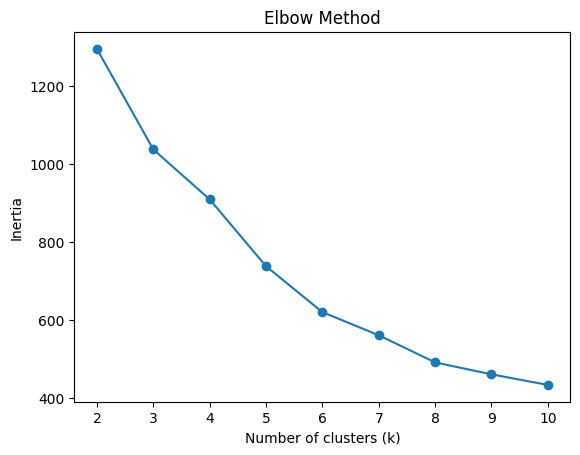

In [32]:
# Use elbow method to define optimal number of clusters
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
K = range(2, 11)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    inertias.append(km.inertia_)

plt.plot(K, inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()


In [33]:
# Fit model based off elbow method
KMeans_model = KMeans(n_clusters=5, random_state=42)
clusters = KMeans_model.fit_predict(X)
print("KMeans clustering completed.")

train_data["cluster"] = clusters

print(train_data["cluster"].value_counts().sort_index())

KMeans clustering completed.
cluster
0    241
1     15
2    134
3      7
4     34
Name: count, dtype: int64


In [34]:
# See average behaviour per cluster
behaviour_cols = [
    "request_count",
    "unique_requests",
    "status_401_count",
    "status_403_count",
    "status_429_count",
    "avg_response_size",
]

print(
    train_data
    .groupby("cluster")[behaviour_cols]
    .mean()
)


         request_count  unique_requests  status_401_count  status_403_count  \
cluster                                                                       
0             2.659751         2.647303               0.0               0.0   
1            40.133333        32.466667               0.0               0.0   
2             4.216418         4.208955               0.0               0.0   
3            54.428571        46.714286               0.0               0.0   
4             6.764706         4.176471               0.0               0.0   

         status_429_count  avg_response_size  
cluster                                       
0                     0.0         177.141079  
1                     0.0        1419.722740  
2                     0.0         851.701493  
3                     0.0         191.829365  
4                     0.0         686.653047  


In [35]:
# See what requests are common in each cluster

terms = vectorizer.get_feature_names_out()

for i in sorted(train_data["cluster"].unique()):
    center = KMeans_model.cluster_centers_[i][:len(terms)]
    top_terms = np.argsort(center)[-10:]

    print(f"\nCluster {i} top request terms:")
    print([terms[t] for t in top_terms])



Cluster 0 top request terms:
['apis', 'html', 'php', 'admin', 'wp', 'api', 'env', 'login', 'http', 'get']

Cluster 1 top request terms:
['login', 'http', 'get', 'src', 'vendor', 'util', 'stdin', 'eval', 'php', 'phpunit']

Cluster 2 top request terms:
['includes', 'api', 'docs', 'service', 'admin', 'php', 'login', 'wp', 'http', 'get']

Cluster 3 top request terms:
['api', 'js', 'maint', 'colors', 'css', 'http', 'get', 'admin', 'php', 'wp']

Cluster 4 top request terms:
['phpunit', 'login', 'index', 'json', 'api', 'admin', 'php', 'get', 'wp', 'http']
